<a href="https://www.kaggle.com/code/s4vyss/reinforcementagent?scriptVersionId=177478060" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tfprioritizedreplaybuffer/TFPrioritizedReplayBuffer.py
/kaggle/input/binanceusdbtc/train (2).csv
/kaggle/input/binanceusdbtc/valid.csv
/kaggle/input/binanceusdbtc/test.csv


1. **Train, test, valid** DONE
2. **Check why only performs one action** DONE
3. **Figure out a way with tensorboard, and other visualization/logging methods**
4. Checkout the things with the action DONE
5. Checkout the algorithm from the repo
6. Understand the model better, and tune it
7. look how to get the z cols
8. use the trademaster feature creator https://github.dev/TradeMaster-NTU/TradeMaster/blob/1.0.0/tutorial/Tutorial9_Feature_Generation.ipynb
9. Try to design a better reward function, that would take exceeding safety threshold into account

## 10. Transform the driver into Episode driver, (includes, changing the agent, net etc.

!git clone -b 1.0.0 https://github.com/TradeMaster-NTU/TradeMaster.git

%cd '/kaggle/working/TradeMaster'

import pandas as pd

df = pd.DataFrame(pd.read_csv("/kaggle/working/TradeMaster/data/portfolio_management/dj30/train.csv"))
df.head()

In [2]:
#!pip install -r requirements.txt

In [3]:
!pip install tf-agents[reverb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 76.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 19.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697629 sha256=8fa179f3f1e690c3f8257e94bdd68b8ba9de8bfca4259b2576006caf460e1311
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym
  Attempting uninsta

In [ ]:
!pip install gym-trading-env stable-baselines3[extra] sb3-contrib pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 7.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of sb3-contrib to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 24.9 MB/s eta 0:00:00
  Installing build dependencies ... -

In [ ]:
import gymnasium as gym
import gym_trading_env

!pip install --upgrade pyarrow

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

num_cols = df.select_dtypes(include=['number']).columns

scaled_data = standard_scaler.fit_transform(df[num_cols])
df = pd.DataFrame(scaled_data, columns=num_cols)

scaled_data

In [ ]:
import tf_agents

def compute_rsi(close_prices, window=14):
    """
    Compute the Relative Strength Index (RSI) for a given series of close prices.
    
    Parameters:
    - close_prices (pd.Series): Series of close prices.
    - window (int): Window size for computing RSI. Default is 14.
    
    Returns:
    - rsi (pd.Series): Series containing RSI values.
    """
    delta = close_prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(close_prices, short_window=12, long_window=26, signal_window=9):
    """
    Compute the Moving Average Convergence Divergence (MACD) for a given series of close prices.
    
    Parameters:
    - close_prices (pd.Series): Series of close prices.
    - short_window (int): Short window size for MACD. Default is 12.
    - long_window (int): Long window size for MACD. Default is 26.
    - signal_window (int): Signal window size for MACD. Default is 9.
    
    Returns:
    - macd (pd.Series): Series containing MACD values.
    """
    short_ema = close_prices.ewm(span=short_window, min_periods=1).mean()
    long_ema = close_prices.ewm(span=long_window, min_periods=1).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1).mean()
    macd = macd_line - signal_line
    return macd

def detect_bullish_engulfing(df):
    """
    Detect bullish engulfing candlestick pattern in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing OHLC data.
    
    Returns:
    - bullish_engulfing (pd.Series): Series indicating bullish engulfing pattern (1 for True, 0 for False).
    """
    bullish_engulfing = np.zeros(len(df))
    for i in range(1, len(df)):
        if df['open'].iloc[i] < df['close'].iloc[i-1] and df['close'].iloc[i] > df['open'].iloc[i-1] and \
           df['close'].iloc[i] > df['open'].iloc[i] and df['open'].iloc[i] < df['close'].iloc[i-1]:
            bullish_engulfing[i] = 1
    return pd.Series(bullish_engulfing, index=df.index)

for key, df in enumerate([train, valid, test]):
    for column in ["open", "high", "low"]:
        df["feature_z_"+column] = df[column] / df["close"] - 1
    df["feature_z_close"] = df["close"] / df["close"].shift(1) - 1
    df["feature_adj_close"] = df["close"] * 0.8535
    df["feature_z_adj_close"] = df["feature_adj_close"] / df["feature_adj_close"].shift(1) - 1
    
    for column in range(5, 31, 5):
        df["feature_z_d"+str(column)] = (df['feature_adj_close'].rolling(window=5, min_periods=1).sum() / 5) / df["feature_adj_close"] - 1

    df['feature_price_spread'] = df['high'] - df['low']
    df['feature_price_momentum'] = df['close'].diff()  # Change in close price
    df['feature_rsi'] = compute_rsi(df['close'])  # Relative Strength Index (RSI)
    df['feature_ema_10'] = df['close'].ewm(span=10, adjust=False).mean()  # 10-period Exponential Moving Average

    # Volume-related features
    df['feature_volume_spread'] = df['high'] - df['low']
    df['feature_volume_momentum'] = df['volume'].diff()  # Change in volume
    df['feature_vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()  # Volume Weighted Average Price

    # Candlestick patterns and technical indicators
    df['feature_bullish_engulfing'] = detect_bullish_engulfing(df)  # Bullish Engulfing Candlestick Pattern
    df['feature_macd'] = compute_macd(df['close'])  # Moving Average Convergence Divergence (MACD)

    # Time-related features
    df['feature_hour_of_day'] = df['date_close'].dt.hour
    df['feature_day_of_week'] = df['date_close'].dt.dayofweek

    # Derived features
    df['feature_price_rate_of_change'] = df['close'].pct_change() * 100
    df['feature_volume_rate_of_change'] = df['volume'].pct_change() * 100
    df['feature_price_to_volume_ratio'] = df['close'] / df['volume']
    
    df["feature_close"] = df["close"]

    df["feature_open"] = df["open"]

    df["feature_high"] = df["high"]

    df["feature_low"] = df["low"]

    df["feature_volume"] = df["volume"]
    
    df['price_spread'] = df['high'] - df['low']
    df['price_momentum'] = df['close'].diff()  # Change in close price
    
    df.dropna(inplace= True)
    df.to_csv(f"data{key}.csv", index=False)
    

In [ ]:
train = pd.DataFrame(pd.read_csv("/kaggle/input/binanceusdbtc/train (2).csv"))
test = pd.DataFrame(pd.read_csv("/kaggle/input/binanceusdbtc/test.csv"))
valid = pd.DataFrame(pd.read_csv("/kaggle/input/binanceusdbtc/valid.csv"))

In [ ]:
train.info()

In [ ]:
train.drop(columns=["date_close"], inplace=True)
valid.drop(columns=["date_close"], inplace=True)
test.drop(columns=["date_close"], inplace=True)

In [ ]:
train.info()

In [ ]:
z_cols = [col for col in train.columns if col.startswith('z_')]
train[z_cols].info()

In [ ]:
train[z_cols].head()

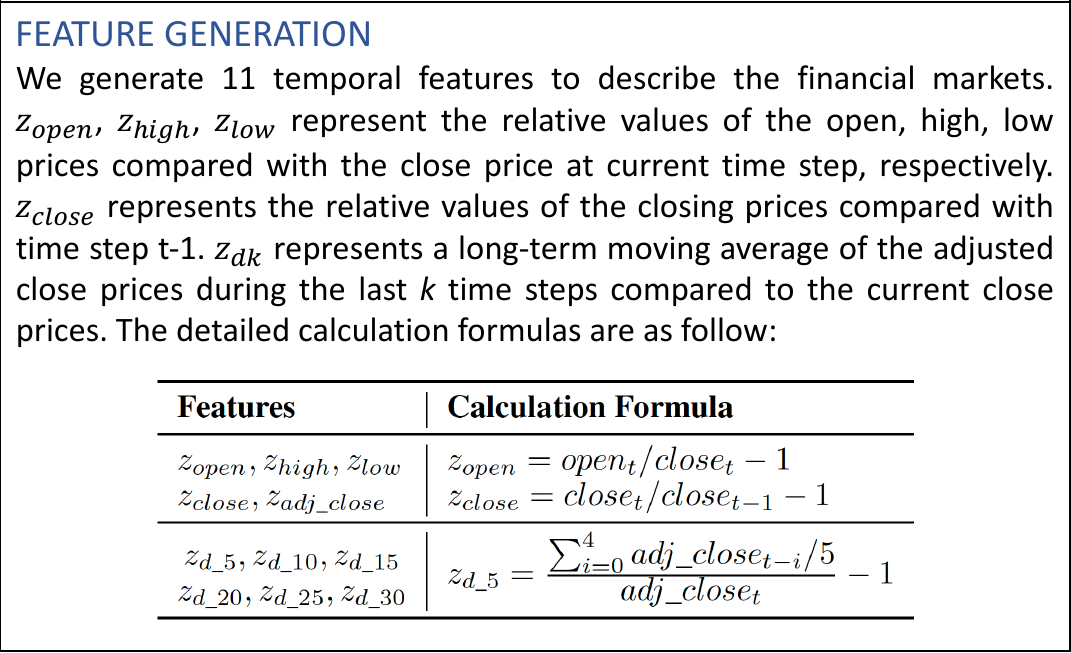

df['price_spread'] = df['high'] - df['low']
    df['price_momentum'] = df['close'].diff()  # Change in close price
    df['rsi'] = compute_rsi(df['close'])  # Relative Strength Index (RSI)
    df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()  # 10-period Exponential Moving Average

    # Volume-related features
    df['volume_spread'] = df['high'] - df['low']
    df['volume_momentum'] = df['volume'].diff()  # Change in volume
    df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()  # Volume Weighted Average Price

    # Candlestick patterns and technical indicators
    df['bullish_engulfing'] = detect_bullish_engulfing(df)  # Bullish Engulfing Candlestick Pattern
    df['macd'] = compute_macd(df['close'])  # Moving Average Convergence Divergence (MACD)

    # Time-related features
    df['hour_of_day'] = df['date_close'].dt.hour
    df['day_of_week'] = df['date_close'].dt.dayofweek

    # Derived features
    df['price_rate_of_change'] = df['close'].pct_change() * 100
    df['volume_rate_of_change'] = df['volume'].pct_change() * 100
    df['price_to_volume_ratio'] = df['close'] / df['volume']

In [ ]:
train.head()

In [ ]:
import numpy as np

num_elements_edges = 5  # Near -2 and 2
num_elements_center = 29  # Near 0
num_elements_transition = 4  # Transition regions

# Create ranges for each section
range_edges = np.linspace(-2, -1, num_elements_edges // 2).tolist() + \
              np.linspace(-1, 1, num_elements_transition).tolist() + \
              np.linspace(1, 2, num_elements_edges // 2).tolist()

range_center = np.linspace(-2, 2, num_elements_center).tolist()

# Include 0, 1, and -1
actions = [-1, 0, 1]

# Concatenate the ranges with the additional actions
positions = actions + range_edges + range_center
positions = [-1, 0, 1, -2.0, -1.0, -1.0, -0.33333333333333337, 0.33333333333333326, 1.0, 1.0, 2.0, -2.0, -1.8571428571428572, -1.7142857142857144, -1.5714285714285714, -1.4285714285714286, -1.2857142857142858, -1.1428571428571428, -1.0, -0.8571428571428572, -0.7142857142857144, -0.5714285714285716, -0.4285714285714286, -0.2857142857142858, -0.14285714285714302, 0.0, 0.1428571428571428, 0.2857142857142856, 0.4285714285714284, 0.5714285714285712, 0.714285714285714, 0.8571428571428568, 1.0, 1.1428571428571428, 1.2857142857142856, 1.4285714285714284, 1.5714285714285712, 1.714285714285714, 1.8571428571428568, 2.0]

In [ ]:
import numpy as np

def reward_function(history):
    portfolio_growth = history["portfolio_valuation", -1] / history["portfolio_valuation", -2]
    reward = np.log(portfolio_growth)
    return reward


In [ ]:
env = gym.make("TradingEnv",
        name= "BTCUSD",
        df=train,
        positions = positions, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        verbose=1,
        windows=5,
        reward_function = reward_function
)

In [ ]:
env

In [ ]:
observation = env.reset()
print(observation)

1002.87

In [ ]:
env.reset()
env.step(0)

In [ ]:
for _ in range(120):
    position_index = env.action_space.sample()
    observation, reward, done, truncated, info = env.step(position_index)
print(info)

In [ ]:
env.action_space

In [ ]:
import tensorflow as tf
from tensorflow import keras

from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import RecurrentPPO, TRPO

log_dir = "/kaggle/working/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

total_timesteps = 10_000

eval_env = gym.make("TradingEnv",
        name= "BTCUSD",
        df=valid,
        positions = positions, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        verbose=1,
        reward_function = lambda history: reward_function(history)
)

env = gym.make("TradingEnv",
        name= "BTCUSD",
        df=train,
        positions = positions, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        verbose=1,
        reward_function = lambda history: reward_function(history)
)


#eval_env = make_vec_env(lambda: eval_env, n_envs=1, monitor_dir=log_dir)
#env = make_vec_env(lambda: env, n_envs=1, monitor_dir=log_dir)

#eval_callback = EvalCallback(eval_env, best_model_save_path="/kaggle/working/logs/",
                             #log_path="/kaggle/working/logs/",
                             #deterministic=True, render=False, verbose=1)

model = TRPO("MlpPolicy", env, verbose=1, tensorboard_log="/kaggle/working/tensorboard", n_steps=2048, batch_size=512) 
model.learn(total_timesteps=total_timesteps, log_interval=100)

from tqdm import tqdm
import typing
from typing import Callable, List, Optional, Tuple, Union
from stable_baselines3.common.vec_env import VecEnv

actions = []
rewards = []
infos = []

def evaluate_policy(
    model: "BaseRLModel",
    env: Union[gym.Env, VecEnv],
    n_eval_episodes: int = 10,
    deterministic: bool = True,
    render: bool = False,
    callback: Optional[Callable] = None,
    reward_threshold: Optional[float] = None,
    return_episode_rewards: bool = True,
) -> Union[Tuple[float, float], Tuple[List[float], List[int]]]:
    if isinstance(env, VecEnv):
        assert env.num_envs == 1, "You must pass only one environment when using this function"

    env = make_vec_env(lambda: env, n_envs=1, monitor_dir=log_dir)
    episode_rewards, episode_lengths = [], []
    for i in range(n_eval_episodes):
        if not isinstance(env, VecEnv) or i == 0:
            obs = env.reset()
            zero_completed_obs = np.zeros((model.n_envs,) + model.observation_space.shape)
            zero_completed_obs[0, :] = obs
            obs = zero_completed_obs
        done, state = False, None
        episode_reward = 0.0
        episode_length = 0
        with tqdm(total=len(valid)) as pbar:
            while True:
                action, state = model.predict(obs, state=state, deterministic=deterministic)
                actions.append(action)
                new_obs, reward, done, _info = env.step(action)
                rewards.append(reward)
                infos.append(_info)
                obs[0, :] = new_obs
                episode_reward += reward
                episode_length += 1
                if done:
                    print("info", _info)
                    break
                pbar.update(1)
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    if reward_threshold is not None:
        assert mean_reward > reward_threshold, "Mean reward below threshold: {:.2f} < {:.2f}".format(mean_reward, reward_threshold)
    if return_episode_rewards:
        print(episode_rewards, episode_lengths)
    print(mean_reward, std_reward)

env.env.save_for_render(dir="/kaggle/working/logs/train")

evaluate_policy(model, eval_env, n_eval_episodes=1, deterministic=True)

eval_env.env.save_for_render(dir="/kaggle/working/logs/eval")

import matplotlib.pyplot as plt

# Sample data
steps = range(len(actions))

# Plot actions
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(steps, actions)
plt.title('Actions')

# Plot rewards
plt.subplot(3, 1, 2)
plt.plot(steps, rewards)
plt.title('Rewards')

# Plot additional information
plt.subplot(3, 1, 3)
# Plot your additional information here

plt.tight_layout()
plt.show()

model.policy

print(stop)

In [ ]:
from tf_agents.environments import TFPyEnvironment, suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tensorflow.python.framework import tensor_spec as tensor_s

class ModifiedTimeStep(ts.TimeStep):
    def __new__(cls, step_type, reward, discount, observation, info):
        return super(ModifiedTimeStep, cls).__new__(cls, step_type, reward, discount, observation, info)

class GymWrapper(py_environment.PyEnvironment):
    def __init__(self, gym_env):
        super(GymWrapper, self).__init__()
        self._gym_env = gym_env
        self._action_spec = self._get_action_spec()
        self._observation_spec = self._get_observation_spec()
                                   # 'observation': array_spec.ArraySpec(shape=(33,), dtype=np.float32, name="Observation"),
                                    #'info': array_spec.ArraySpec(shape=(21, ), dtype=np.object_, name="Info")
                                 #}
        self._reward_spec = self._get_reward_spec()
        self._step_type_spec = self._get_step_type_spec()
        self._discount_spec = self._get_discount_spec()
        self._info_buffer = []
          
    def _get_reward_spec(self):
        return tf.TensorSpec(shape=(), dtype=np.float32, name='reward')
        
    def _get_action_spec(self):
        action_space = self._gym_env.action_space
        if isinstance(action_space, gym.spaces.Box):
            return tensor_s.BoundedTensorSpec(
                shape=action_space.shape,
                dtype=action_space.dtype,
                minimum=action_space.low,
                maximum=action_space.high
            )
        elif isinstance(action_space, gym.spaces.Discrete):
            return tensor_s.BoundedTensorSpec(
                shape=(),
                dtype=action_space.dtype,
                minimum=0,
                maximum=action_space.n-1
            )
        else:
            raise ValueError(f"Unsupported action space type: {type(action_space)}")

    def _get_observation_spec(self):
        observation_space = self._gym_env.observation_space
        return tf.TensorSpec(
            shape=observation_space.shape,
            dtype=observation_space.dtype
        )
    
    def _get_step_type_spec(self):
        return tf.TensorSpec(shape=(), dtype=np.int32, name='step_type')
    
    def _get_discount_spec(self):
        return tensor_s.BoundedTensorSpec(shape=(), dtype=np.float32, name='discount', minimum=0.0, maximum=1.0)

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def reward_spec(self):
        return self._reward_spec
    
    def step_type_spec(self):
        return self._step_type_spec

    def discount_spec(self):
        return self._discount_spec
    
    def logging_buffer(self):
        return self._info_buffer[-1]

    def _reset(self):
        obs = self._gym_env.reset()

        # Check if obs is a tuple/list containing the observation array and info dict
        if isinstance(obs, tuple) or isinstance(obs, list):
            observation = obs[0]  # Extract the actual observation array
        else:
            observation = obs  # obs is already the observation array

        return ts.restart(observation)

    def _step(self, action):
        obs, reward, done, truncated, info = self._gym_env.step(action)
        
        self._info_buffer.append(info)
        
        if 'portfolio_valuation' in info and info['portfolio_valuation'] < 100:
            # Terminate the episode
            return ts.termination(obs, reward)

        if done or truncated:
            return ts.termination(obs, reward)
        else:
            return ts.transition(obs, reward)

In [ ]:
env = gym.make("TradingEnv",
        name= "BTCUSD",
        df=train,
        positions = positions, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        verbose=1,
        reward_function = lambda history: reward_function(history)
)

tf_env = GymWrapper(env)

#tf_env = TFPyEnvironment(gym_env)

In [ ]:
tf_env.observation_spec()

In [ ]:
tf_env.step(1)

In [ ]:
tf_env.time_step_spec()

In [ ]:
import tensorflow as tf
import tf_agents
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"TF-Agents version: {tf_agents.__version__}")


In [ ]:
from tf_agents.environments import tf_py_environment
tf_env = tf_py_environment.TFPyEnvironment(tf_env)

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.networks import encoding_network
from tf_agents.networks import value_network

lstm_size=(512,)

# Combine the encoding and value networks
q_net = QRnnNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    lstm_size=lstm_size,
)

train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250_000,
    end_learning_rate=0.01
)

agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2_000,
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=0.99,
    train_step_counter=train_step,
    epsilon_greedy=lambda: epsilon_fn(train_step)
)

agent.initialize()

In [ ]:
import sys
sys.path.append("/kaggle/input/tfprioritizedreplaybuffer")

In [ ]:
from TFPrioritizedReplayBuffer import TFPrioritizedReplayBuffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=1,
    max_length=1_000_000
)

replay_buffer_observer = replay_buffer.add_batch

In [ ]:
q_net.summary()

In [ ]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [ ]:
from tf_agents.metrics.tf_metric import TFStepMetric
import tensorflow as tf

class PortfolioValuationMetric(TFStepMetric):
    def __init__(self, name='PortfolioValuation', batch_size=1):
        super(PortfolioValuationMetric, self).__init__(name=name)
        self._batch_size = batch_size
        self._portfolio_valuation = tf.Variable(tf.zeros(shape=(batch_size,), dtype=tf.float32), trainable=False, name='portfolio_valuation')

    def call(self, observation):
        """
        Update the metric's state with the current portfolio valuation.
        
        Args:
            observation: A dictionary containing the current observation, including the 'portfolio_valuation' key.
        """
        self._portfolio_valuation.assign(observation['portfolio_valuation'] - 1000)

    def result(self):
        """
        Return the current portfolio valuation.
        """
        return self._portfolio_valuation

    def reset(self):
        """
        Reset the metric's internal state.
        """
        self._portfolio_valuation.assign(tf.zeros(shape=(self._batch_size,), dtype=tf.float32))


In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [ ]:
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [ ]:
tf_env.time_step_spec()

In [ ]:
tf_env.action_spec()

In [ ]:
tf_env.step(1)

In [ ]:
tf_env.current_time_step()

In [ ]:
import numpy as np

def check_nested_data_types(data):
    if isinstance(data, np.ndarray):
        print("Array data type:", data.dtype)
    elif isinstance(data, dict):
        for key, value in data.items():
            print(f"Key: {key}")
            check_nested_data_types(value)
    elif isinstance(data, list):
        for item in data:
            check_nested_data_types(item)
    else:
        print("Data type:", type(data))

observation = tf_env.current_time_step().observation
check_nested_data_types(observation)

In [ ]:
import numpy as np

def check_nested_data_types(data):
    if isinstance(data, np.ndarray):
        print(f"Array data type: {data.dtype}")
        if data.dtype == np.dtype('datetime64') or data.dtype == np.dtype('object'):
            print("Timestamp data type found!")
    elif isinstance(data, dict):
        for key, value in data.items():
            print(f"Key: {key}")
            check_nested_data_types(value)
    elif isinstance(data, list):
        for item in data:
            check_nested_data_types(item)
    else:
        print(f"Data type: {type(data)}")

time_step = tf_env.current_time_step()
check_nested_data_types(time_step)



In [ ]:
tf_env.time_step_spec()

In [ ]:
tf_env.observation_spec()

In [ ]:
obs, _, _, _ = tf_env.step(1)

In [ ]:
tf_env.step(1)

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20_000)],
    num_steps=1000
)

final_time_step, final_policy_state = init_driver.run()

In [ ]:
final_time_step

In [ ]:
final_policy_state

In [ ]:
trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3
)

trajectories._fields

In [ ]:
trajectories.observation.shape

In [ ]:
trajectories.step_type.numpy()

In [ ]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

In [ ]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3
).prefetch(3)

In [ ]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [ ]:
from tf_agents.eval.metric_utils import log_metrics

def log_stuff(train_metrics):
    log_metrics(train_metrics)

    metric_names = ["NumberOfEpisodes", "EnvironmentSteps", "AverageReturnMetric", "AverageEpisodeLengthMetric", "PortfolioValuationMetric"]

    for i, metric in enumerate(train_metrics):
        print(f"{metric_names[i]}: {metric.result().numpy()}")

In [ ]:
tf_env.reset()

In [ ]:
def train_agent(n_iterations):
    time_step, policy_state = collect_driver.run()
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        if time_step.is_last():
            print(policy_state, iteration, time_step)
            time_step = tf_env.reset()
            print(time_step)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} F. straty:{:.5f}".format(
            iteration, train_loss.loss
        ), end="")
        if iteration % 1000 == 0:
            print("\n=============\n")
            log_stuff(train_metrics)
            log = tf_env.envs[0].logging_buffer()
            print("=============\n")
            print(log['portfolio_valuation'])
            print("=============\n")

In [ ]:
train_agent(10_000_000)

In [ ]:
 target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
import numpy as np

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        # Ensure state is a numpy array and has the correct shape for model.predict
        if not isinstance(state, np.ndarray):
            state = np.array(state[0])
        if len(state.shape) == 1: # If state is a 1D array, add an extra dimension
            state = state[np.newaxis, :]
        
        Q_values = model.predict(state, verbose=False)
        return np.argmax(Q_values[0])

In [ ]:
from collections import deque

replay_buffer = deque(maxlen=len(df))

In [ ]:
def extract_array(output):
    if isinstance(output, tuple) and len(output) == 2:
        array, obj = output
        if isinstance(array, list) or isinstance(array, np.ndarray):
            if isinstance(obj, dict):
                return array
    return output

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones, truncatedes = [
        np.array([extract_array(experience[field_index]) for experience in batch])
        for field_index in range(6)
    ]
    return states, actions, rewards, next_states, dones, truncatedes

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [ ]:
batch_size = 64
discount_factor = 0.3
optimizer = keras.optimizers.Adam(learning_rate=1e-5 )
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncatedes = experiences
    next_Q_values = model.predict(next_states, verbose=False)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, env.action_space.n).numpy()
    next_best_Q_values = (target.predict(next_states, verbose=False) * next_mask).sum(axis=1)
    target_Q_values = (rewards + (1 - truncatedes) * discount_factor * next_best_Q_values)
    mask = tf.one_hot(actions, env.action_space.n)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
import logging

# Disable logging
logging.disable(logging.CRITICAL)

for episode in range(50):
    obs = env.reset()
    for step in range(len(df)):
        epsilon = max(1 - episode / 50, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    if episode > 5:
        training_step(batch_size)
        print(f"Reward for episode: {episode} is {reward}")
    if episode % 5 == 0:
        target.set_weights(model.get_weights())

In [ ]:
env.unwrapped.get_metrics

In [ ]:
episode_data[-1]